<a href="https://colab.research.google.com/github/sergeevgithub/SRGAN_bot/blob/main/Srgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

import os
from PIL import Image
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [ ]:
im = Image.open("/kaggle/input/div2k-x2/DIV2K_valid_LR_bicubic/X2/0869x2.png")
both_transforms = transforms.Compose([
            transforms.RandomCrop(size=(320, 320)),
            transforms.Resize(size=(256, 256), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.RandomHorizontalFlip(p=0.5),
        ])
hr_transforms = transforms.Compose([
            transforms.ToTensor(),
#             transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
lr_transforms = transforms.Compose([
            transforms.Resize(size=(64, 64), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.ToTensor(),
#             transforms.Normalize(mean=(0, 0, 0), std=(1, 1, 1)),
#             transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
im_trf = both_transforms(im)
lr = transforms.ToPILImage()(lr_transforms(im_trf))
hr = transforms.ToPILImage()(hr_transforms(im_trf))

# save_image(lr_transforms(im_trf), f'lr.png')
# save_image(hr_transforms(im_trf), f'hr.png')

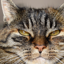

In [ ]:
lr

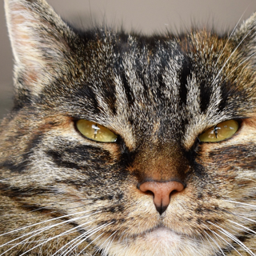

In [ ]:
hr

# Data loading

In [ ]:
test_trf = transforms.Compose([
    transforms.Resize(size=(510 // 4, 339 // 4), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
])

real_trf = transforms.Compose([
    transforms.Resize(size=(510, 339), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
])

test = test_trf(im)
real = real_trf(im)
# save_image(test, f'test_image.png')
# save_image(real, f'real_image.png')

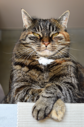

In [ ]:
transforms.ToPILImage()(test)

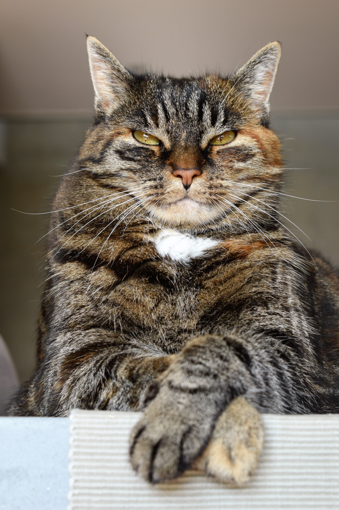

In [ ]:
transforms.ToPILImage()(real)

In [ ]:
# Image.open("./real_image.png")

In [ ]:
# os.remove("./lr_upscaled.png")

In [ ]:
class CustomImageFolder(Dataset):
    def __init__(self, root_dir):
        super().__init__()
        self.root_dir = root_dir
        self.data = os.listdir(root_dir)

        self.both_transforms = transforms.Compose([
            transforms.RandomCrop(size=(320, 320)),
            transforms.Resize(size=(256, 256), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.RandomHorizontalFlip(p=0.5),
        ])

        self.hr_transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

        self.lr_transforms = transforms.Compose([
            transforms.Resize(size=(64, 64), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.ToTensor(),
        ])



    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_file = self.data[index]
        image = Image.open(os.path.join(self.root_dir, img_file))
        image = self.both_transforms(image)
        hr_img = self.hr_transforms(image)
        lr_img = self.lr_transforms(image)
        return lr_img, hr_img

# Generator and discriminator

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_c):
        super().__init__()
        self.res_block = nn.Sequential(
            nn.Conv2d(in_c, in_c, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_c),
            nn.PReLU(num_parameters=in_c),
            nn.Conv2d(in_c, in_c, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_c)
        )

    def forward(self, x):
        return x + self.res_block(x)


class UpsampleBlock(nn.Module):
    def __init__(self, in_c, scale_factor):
        super().__init__()
        self.conv = nn.Conv2d(in_c, in_c * scale_factor ** 2, 3, 1, 1)
        self.ps = nn.PixelShuffle(scale_factor)
        self.act = nn.PReLU(num_parameters=in_c)

    def forward(self, x):
        return self.act(self.ps(self.conv(x)))


class Generator(nn.Module):
    def __init__(self, in_c=3, num_c=64, num_res_blocks=16):
        super().__init__()
        # Enter layer
        self.enter_layer = nn.Sequential(
            nn.Conv2d(in_c, num_c, kernel_size=9, stride=1, padding=4),
            nn.PReLU(num_parameters=num_c)
        )
        # Residual layers
        self.res_layers = nn.Sequential(*[ResidualBlock(num_c) for _ in range(num_res_blocks)])
        # Post residual layer
        self.postres_layer = nn.Sequential(
            nn.Conv2d(num_c, num_c, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_c)
        )
        # Upsampling layers
        self.upsample_layers = nn.Sequential(UpsampleBlock(num_c, 2), UpsampleBlock(num_c, 2))
        # Output layer
        self.output = nn.Conv2d(num_c, in_c, kernel_size=9, stride=1, padding=4)

    def forward(self, x):
        out1 = self.enter_layer(x)       # goes to skip connection
        x = self.res_layers(out1)
        x = self.postres_layer(x) + out1 # skip connection
        x = self.upsample_layers(x)
        return torch.tanh(self.output(x))


class DiscBlock(nn.Module):
    def __init__(self, in_c, out_c, use_bn=True, **kwargs):
        super().__init__()
        self.cnn = nn.Conv2d(in_c, out_c, **kwargs) # bias=not use_bn
        self.bn = nn.BatchNorm2d(out_c) if use_bn else nn.Identity()
        self.act = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        return self.act(self.bn(self.cnn(x)))


class Discriminator(nn.Module):
    def __init__(self, in_c=3, features=[64, 64, 128, 128, 256, 256, 512, 512]):
        super().__init__()
        # Blocks
        blocks = []
        for idx, feature in enumerate(features):
            blocks.append(
                DiscBlock(
                    in_c,
                    feature,
                    kernel_size=3,
                    stride=1 + idx % 2,
                    padding=1,
                    use_bn=False if idx == 0 else True
                )
            )
            in_c = feature

        self.blocks = nn.Sequential(*blocks)
        # Dense layer
        self.dense_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 16 * 512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1)
        )


    def forward(self, x):
        x = self.blocks(x)
#         print(x.shape)
        return self.dense_layer(x)

## VGG features

In [ ]:
class VGGFeatures(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = models.vgg19(pretrained=True).features[:35].eval()

        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, x):
        return self.vgg(x)

# Initialization

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
LR = 1e-4
BATCH_SIZE = 32
NUM_EPOCH = 500
WARMUP_EPOCH = 200

In [ ]:
disc = Discriminator().to(device)
gen = Generator().to(device)
vgg_extractor = VGGFeatures().to(device)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
dataset = CustomImageFolder(root_dir="/kaggle/input/div2k-x2/DIV2K_train_LR_bicubic/X2")
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Optimizers
opt_disc = optim.Adam(disc.parameters(), lr=LR)
opt_gen = optim.Adam(gen.parameters(), lr=LR)

# Losses
bce = nn.BCEWithLogitsLoss()
mse = nn.MSELoss()

# Training function and utils

In [ ]:
def warmup(loader, gen, opt_gen, mse, epoch):
    gen.train()
    pbar = tqdm(loader)
    epoch_loss_gen = 0.0
    for (lr_images, hr_images) in pbar:
        pbar.set_description(f"Epoch {epoch+1} / {WARMUP_EPOCH}")
        lr_images = lr_images.to(device)
        hr_images = hr_images.to(device)

        # Warm-up generator
        fake = gen(lr_images)
        lossG = mse(fake, hr_images)
        opt_gen.zero_grad()
        lossG.backward()
        opt_gen.step()
        epoch_loss_gen += lossG.item()

    return epoch_loss_gen / len(loader)


def training(loader, disc, gen, vgg_extractor, opt_disc, opt_gen, bce, mse, epoch):
    disc.train()
    gen.train()
    pbar = tqdm(loader)
    epoch_loss_gen = 0.0
    epoch_loss_disc = 0.0
    for (lr_images, hr_images) in pbar:
        pbar.set_description(f"Epoch {epoch+1} / {NUM_EPOCH}")
        lr_images = lr_images.to(device)
        hr_images = hr_images.to(device)

        # Train discriminator
        fake = gen(lr_images).detach()
        logits_fake = disc(fake)
        logits_real = disc(hr_images)
        lossD_real = bce(logits_real, torch.ones_like(logits_real))
        lossD_fake = bce(logits_fake, torch.zeros_like(logits_fake))
        lossD = (lossD_real + lossD_fake) / 2
        opt_gen.zero_grad()
        opt_disc.zero_grad()
        lossD.backward()
        opt_disc.step()

        # Train generator
        fake = gen(lr_images)
        disc_out = disc(fake)
        features_fake = vgg_extractor((fake + 1) / 2)                  # vgg uses input values in range [0, 1]
        features_real = vgg_extractor((hr_images + 1) / 2)             # vgg uses input values in range [0, 1]
        lossG_adv = 1e-3 * bce(disc_out, torch.ones_like(disc_out))
        lossG_cont = 0.006 * mse(features_fake, features_real)
        lossG = lossG_cont + lossG_adv
        opt_gen.zero_grad()
        lossG.backward()
        opt_gen.step()

        epoch_loss_gen += lossG.item()
        epoch_loss_disc += lossD.item()

    return epoch_loss_gen / len(loader), epoch_loss_disc / len(loader)


def denormalize(tensor):
    return tensor * 0.5 + 0.5


def save_checkpoint(model, optimizer, path):
    print("=> Saving checkpoint")
    torch.save({
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict()
                }, path)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=device)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # Update learning rate
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr


def show_info(hr, lr, gen, gen_losses, disk_losses=None):

    # Generate superresolution image
    lr_to_tensor = transforms.ToTensor()(lr)
    gen.eval()
    with torch.no_grad():
        upscaled = denormalize(gen(lr_to_tensor.unsqueeze(0).to(device)))
    gen_img = transforms.ToPILImage()(upscaled.squeeze())
    gen.train()

    # Show images and Loss graph
    gs_kw = dict(height_ratios=[1, 1])
    fig, ax = plt.subplot_mosaic([['upper', 'upper', 'upper'],
                                  [1, 2, 3]],
                                 gridspec_kw=gs_kw, figsize=(14, 8),
                                 constrained_layout=True)
    if disk_losses:
        ax['upper'].plot(disk_losses, label='Disc loss')
    if gen_losses:
        ax['upper'].plot(gen_losses, label='Gen loss')
        ax['upper'].set_title('Loss')
        ax['upper'].set_xlabel('Epoch')
        ax['upper'].legend()
    ax[1].imshow(lr)
    ax[1].set_title('LR Image')
    ax[2].imshow(gen_img)
    ax[2].set_title('Superresolution')
    ax[3].imshow(hr)
    ax[3].set_title('Orig. HR image')
    plt.show()


def show_results(real, test):

    # Generate superresolution image
    gen.eval()
    with torch.no_grad():
        upscaled = denormalize(gen(test.unsqueeze(0).to(device)))
    gen_img = transforms.ToPILImage()(upscaled.squeeze())
    gen.train()

    test_img = transforms.ToPILImage()(test)
    real_img = transforms.ToPILImage()(real)
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 10))
    ax[0].imshow(test_img)
    ax[0].set_title('LR Image')
    ax[1].imshow(gen_img)
    ax[1].set_title('Superresolution')
    ax[2].imshow(real_img)
    ax[2].set_title('Orig. HR image')

    plt.show()

# Warm-up

In [ ]:
gen_losses = []
for epoch in range(warm_up_epochs):
    loss_gen = warmup(loader, gen, opt_gen, mse, epoch)
    gen_losses.append(loss_gen)

    clear_output(True)
    print(f"Epoch {epoch+1} / {warm_up_epochs}\n")
    print(f"Generator loss: {gen_losses[-1]:.5f}\n")
    show_info(hr, lr, gen, gen_losses)

    if epoch % 10 == 9:
        save_checkpoint(gen, opt_gen, path='warmuped_gen.tar')
        show_results(real, test)

In [ ]:
load_checkpoint("/kaggle/input/warmuped/warmuped_gen (1).tar", gen, opt_gen, LR)

=> Loading checkpoint


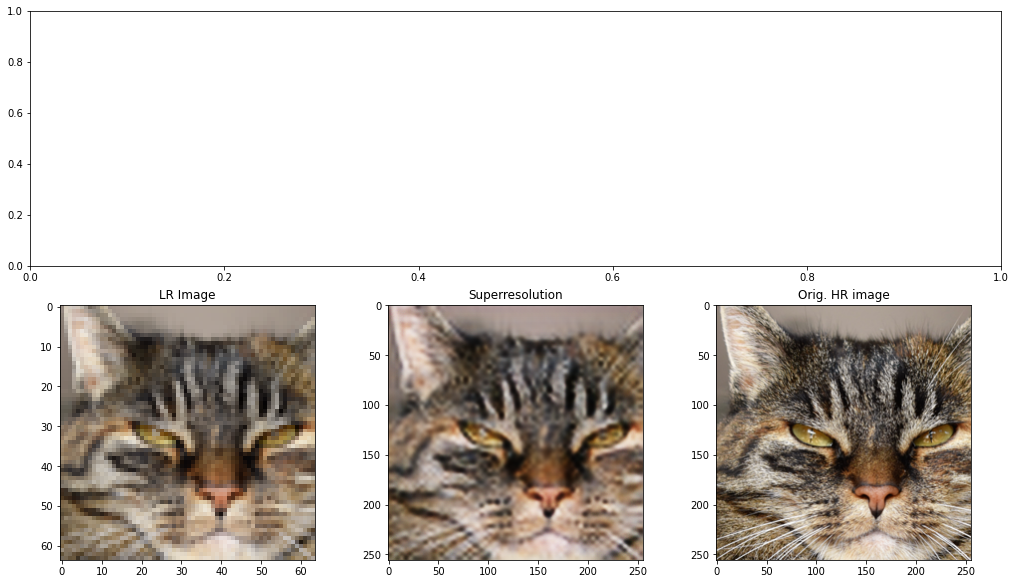

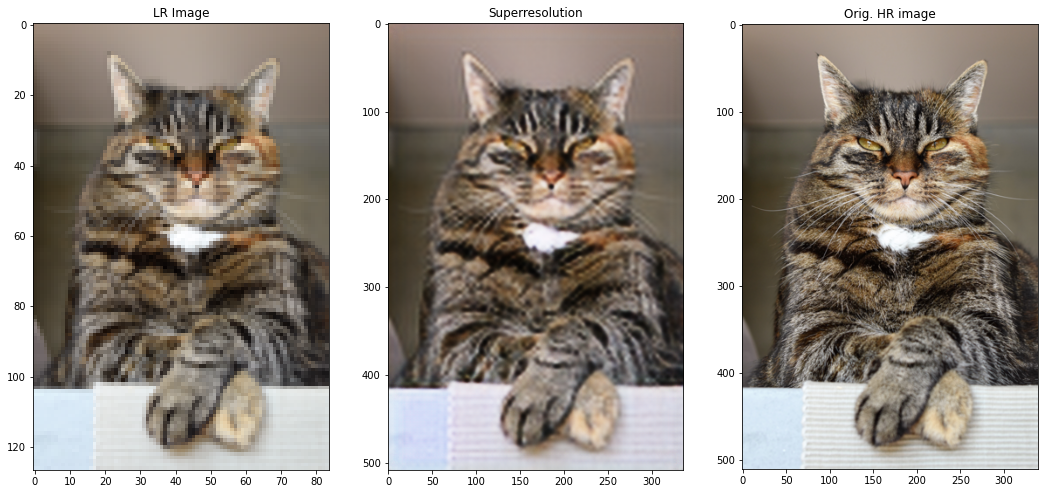

In [ ]:
show_info(hr, lr, gen, gen_losses=[])
show_results(real, test)

# Training


Epoch 500 / 500

Generator loss: 0.01543

Discriminator loss: 0.46878



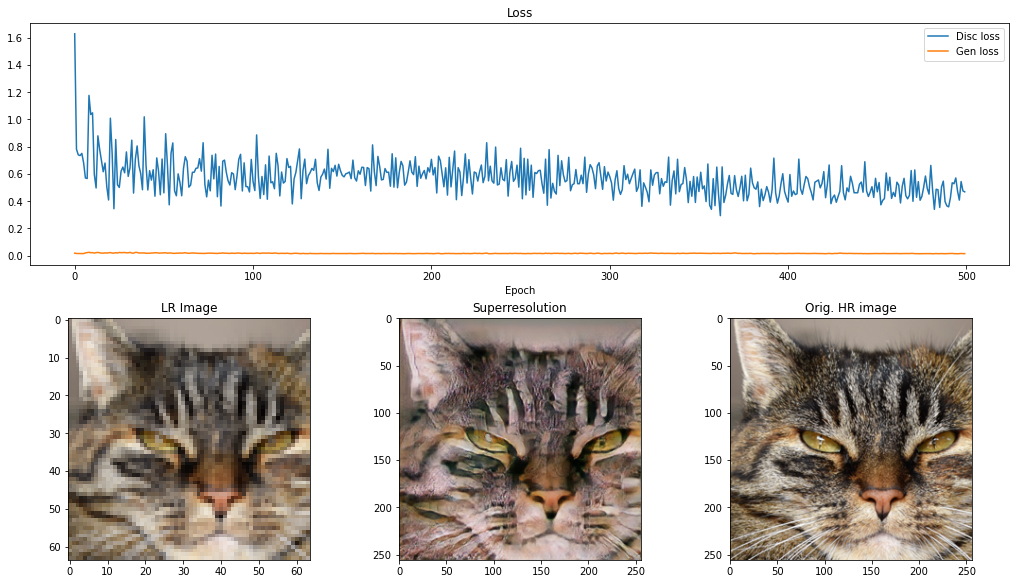

=> Saving checkpoint
=> Saving checkpoint


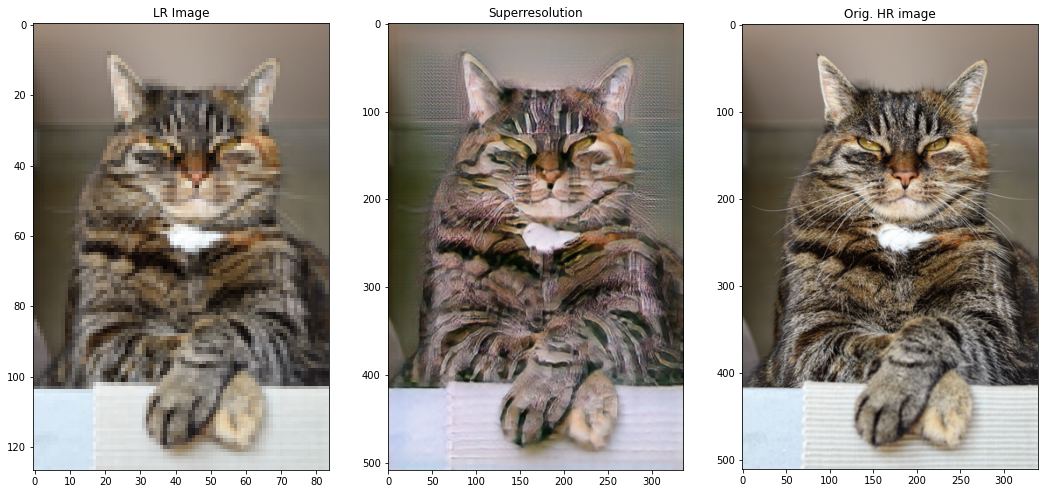

In [ ]:
gen_losses = []
disk_losses = []
for epoch in range(NUM_EPOCH):
    loss_gen, loss_disc = training(loader, disc, gen, vgg_extractor, opt_disc, opt_gen, bce, mse, epoch)
    gen_losses.append(loss_gen)
    disk_losses.append(loss_disc)

    clear_output(True)
    print(f"\nEpoch {epoch+1} / {NUM_EPOCH}\n")
    print(f"Generator loss: {gen_losses[-1]:.5f}\n")
    print(f"Discriminator loss: {disk_losses[-1]:.5f}\n")

    if epoch % 10 == 9:
        show_info(hr, lr, gen, gen_losses=gen_losses, disk_losses=disk_losses)
        save_checkpoint(gen, opt_gen, path='gen.tar')
        save_checkpoint(disc, opt_disc, path='disc.tar')
        show_results(real, test)

<a href="./gen.tar"> Download gen </a>

<a href="./disc.tar"> Download disc </a>